In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Corrigida: time_stretch funciona com STFT
def change_speed(y, sr, rate=1.0):
    try:
        if len(y) < 2:
            raise ValueError("Áudio muito curto para alteração de velocidade.")

        y = y.astype(np.float32)

        # Converter o sinal para o domínio da frequência
        D = librosa.stft(y)

        # Aplicar time-stretch no espectrograma
        D_stretched = librosa.phase_vocoder(D, rate=rate)

        # Converter de volta para o domínio do tempo
        y_stretched = librosa.istft(D_stretched)

        return y_stretched

    except Exception as e:
        print(f"Erro ao alterar velocidade: {e}")
        return y  # Retorna o original em caso de falha


# Função para extrair MFCCs do áudio
def extract_features(y, sr):
    try:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return np.mean(mfccs.T, axis=0)  # Retorna a média dos coeficientes
    except Exception as e:
        print(f"Erro ao extrair MFCCs: {e}")
        return None

# Função para carregar dados e aplicar mudança de velocidade
def load_data_with_speed_variation(folder_path, label):
    data = []
    labels = []

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        try:
            y, sr = librosa.load(file_path, sr=None)

            # Extrair features do áudio original
            features = extract_features(y, sr)
            if features is not None:
                data.append(features)
                labels.append(label)

              # Aplicar uma única variação de velocidade (ex: 0.85)
            rate = 0.85
            y_speed = change_speed(y, rate)
            features_speed = extract_features(y_speed, sr)

            if features_speed is not None:
                  data.append(features_speed)
                  labels.append(label)

        except Exception as e:
            print(f"Erro ao processar {file_path}: {e}")

    return data, labels

In [ ]:
# Definir caminhos dos áudios
file_path_real = '/content/drive/MyDrive/audios_FOR/real'
file_path_fake = '/content/drive/MyDrive/audios_FOR/fake'

# Criar diretórios se não existirem
os.makedirs(file_path_real, exist_ok=True)
os.makedirs(file_path_fake, exist_ok=True)

# Carregar dados com variação de velocidade
data_real, labels_real = load_data_with_speed_variation(file_path_real, label=1)  # Áudios reais
data_fake, labels_fake = load_data_with_speed_variation(file_path_fake, label=0)  # Áudios falsos

# Unir dados reais e falsos
data = data_real + data_fake
labels = labels_real + labels_fake

# Remover valores None
data_filtered, labels_filtered = zip(*[(d, l) for d, l in zip(data, labels) if d is not None])

In [ ]:
def plot_speed_comparison(folder_path, rate=0.85):
    import matplotlib.pyplot as plt
    import librosa.display
    import os

    # Usa o estilo padrão com fundo branco
    plt.style.use('default')

    # Pega o primeiro arquivo da pasta
    first_audio_file = os.listdir(folder_path)[0]
    audio_path = os.path.join(folder_path, first_audio_file)

    # Carrega o áudio
    y, sr = librosa.load(audio_path, sr=None)

    # Altera a velocidade
    y_speed = change_speed(y, sr, rate=rate)

    print(f"Tamanho original: {len(y)} amostras")
    print(f"Tamanho com velocidade alterada (rate={rate}): {len(y_speed)} amostras")

    # Cor preta mais clara
    wave_color = "#333333"  # Cinza escuro

    # Plota o original e com velocidade alterada
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.title("Áudio Original", fontsize=14)
    librosa.display.waveshow(y, sr=sr, color=wave_color)
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")

    plt.subplot(2, 1, 2)
    plt.title(f"Áudio com Velocidade Alterada (rate={rate})", fontsize=14)
    librosa.display.waveshow(y_speed, sr=sr, color=wave_color)
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

Tamanho original: 50481 amostras
Tamanho com velocidade alterada (rate=0.85): 59392 amostras


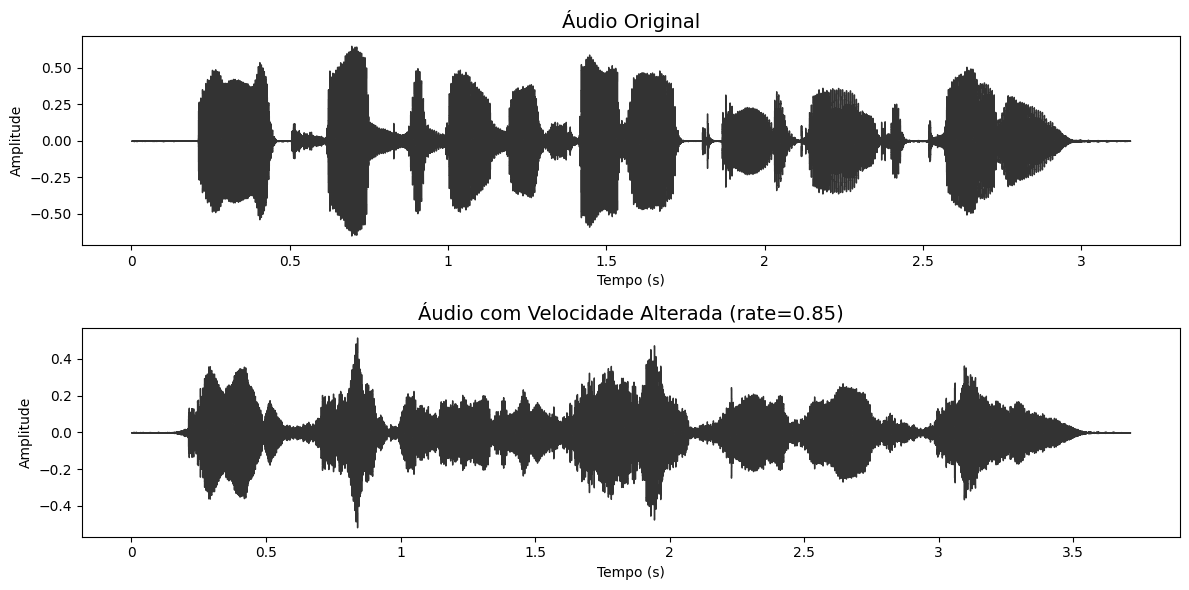

In [ ]:
plot_speed_comparison('/content/drive/MyDrive/audios_FOR/real', rate=0.85)

In [ ]:
# Criar DataFrame
df = pd.DataFrame(data_filtered)
df['label'] = labels_filtered

In [ ]:
df.shape

(1440, 14)

In [ ]:
# Separar características (X) e rótulos (y)
X = df.drop(columns=['label'])
y = df['label']

In [ ]:
# UNDERSAMPLING
under = RandomUnderSampler(random_state=42)
X_under, y_under = under.fit_resample(X, y)
print("Distribuição após undersampling:", Counter(y_under))

Distribuição após undersampling: Counter({0: 410, 1: 410})


In [ ]:
# OVERSAMPLING (SMOTE)
smote = SMOTE(random_state=42)
X_over, y_over = smote.fit_resample(X, y)
print("Distribuição após oversampling:", Counter(y_over))

Distribuição após oversampling: Counter({1: 1030, 0: 1030})


In [ ]:
# Função para calcular e exibir as métricas
def print_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Acurácia: {accuracy:.2f}")
    print(f"Precisão: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("\n")

### Random Forest

In [ ]:
# Dividir em treino e teste
X_train_rf_model, X_test_rf_model, y_train_rf_model, y_test_rf_model = train_test_split(X, y, test_size=0.2, random_state=1)


rf_model = RandomForestClassifier(n_estimators=1, max_features=1)
rf_model.fit(X_train_rf_model, y_train_rf_model)
rf_pred = rf_model.predict(X_test_rf_model)
print("Random Forest:")
print_metrics(y_test_rf_model, rf_pred)

Random Forest:
Acurácia: 0.89
Precisão: 0.91
Recall: 0.93
F1-Score: 0.92




In [ ]:
# Dividir em treino e teste
X_train_rf_model_under, X_test_rf_model_under, y_train_rf_model_under, y_test_rf_model_under = train_test_split(X_under, y_under, test_size=0.2, random_state=1)


rf_model_under = RandomForestClassifier(n_estimators=1, max_features=1)
rf_model_under.fit(X_train_rf_model_under, y_train_rf_model_under)
rf_pred_under = rf_model_under.predict(X_test_rf_model_under)
print("Random Forest (Undersampling):")
print_metrics(y_test_rf_model_under, rf_pred_under)

Random Forest (Undersampling):
Acurácia: 0.87
Precisão: 0.91
Recall: 0.82
F1-Score: 0.86




In [ ]:
# Dividir em treino e teste
X_train_rf_model_over, X_test_rf_model_over, y_train_rf_model_over, y_test_rf_model_over = train_test_split(X_over, y_over, test_size=0.2, random_state=1)


rf_model_over = RandomForestClassifier(n_estimators=1, max_features=1)
rf_model_over.fit(X_train_rf_model_over, y_train_rf_model_over)
rf_pred_over = rf_model_over.predict(X_test_rf_model_over)
print("Random Forest (Oversampling):")
print_metrics(y_test_rf_model_over, rf_pred_over)

Random Forest (Oversampling):
Acurácia: 0.94
Precisão: 0.95
Recall: 0.93
F1-Score: 0.94




### LightGBM

In [ ]:
# Dividir em treino e teste
X_train_lgb_model, X_test_lgb_model, y_train_lgb_model, y_test_lgb_model = train_test_split(X, y, test_size=0.2, random_state=2)

lgb_model = lgb.LGBMClassifier(verbose=-1, n_estimators=1)
lgb_model.fit(X_train_lgb_model, y_train_lgb_model)
lgb_pred = lgb_model.predict(X_test_lgb_model)
print("LightGBM:")
print_metrics(y_test_lgb_model, lgb_pred)

LightGBM:
Acurácia: 0.72
Precisão: 0.72
Recall: 1.00
F1-Score: 0.83




In [ ]:
# LightGBM com undersampling
X_train_lgb_model_under, X_test_lgb_model_under, y_train_lgb_model_under, y_test_lgb_model_under = train_test_split(X_under, y_under, test_size=0.2, random_state=2)

lgb_model_under = lgb.LGBMClassifier(verbose=-1, n_estimators=1)
lgb_model_under.fit(X_train_lgb_model_under, y_train_lgb_model_under)
lgb_pred_under = lgb_model_under.predict(X_test_lgb_model_under)
print("LightGBM (Undersampling):")
print_metrics(y_test_lgb_model_under, lgb_pred_under)

LightGBM (Undersampling):
Acurácia: 0.82
Precisão: 0.85
Recall: 0.80
F1-Score: 0.82




In [ ]:
# LightGBM com oversampling
X_train_lgb_model_over, X_test_lgb_model_over, y_train_lgb_model_over, y_test_lgb_model_over = train_test_split(X_over, y_over, test_size=0.2, random_state=2)

lgb_model_over = lgb.LGBMClassifier(verbose=-1, n_estimators=1)
lgb_model_over.fit(X_train_lgb_model_over, y_train_lgb_model_over)
lgb_pred_over = lgb_model_over.predict(X_test_lgb_model_over)
print("LightGBM (Oversampling):")
print_metrics(y_test_lgb_model_over, lgb_pred_over)

LightGBM (Oversampling):
Acurácia: 0.90
Precisão: 0.94
Recall: 0.86
F1-Score: 0.90




### Naïve Bayes

In [ ]:
# Dividir em treino e teste
X_train_nb_model, X_test_nb_model, y_train_nb_model, y_test_nb_model = train_test_split(X, y, test_size=0.2, random_state=5)

# 3. Naïve Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_nb_model, y_train_nb_model)
nb_pred = nb_model.predict(X_test_nb_model)
print("Naïve Bayes:")
print_metrics(y_test_nb_model, nb_pred)

Naïve Bayes:
Acurácia: 0.83
Precisão: 0.85
Recall: 0.90
F1-Score: 0.88




In [ ]:
# Naïve Bayes com undersampling
X_train_nb_model_under, X_test_nb_model_under, y_train_nb_model_under, y_test_nb_model_under = train_test_split(X_under, y_under, test_size=0.2, random_state=5)

nb_model_under = GaussianNB()
nb_model_under.fit(X_train_nb_model_under, y_train_nb_model_under)
nb_pred_under = nb_model_under.predict(X_test_nb_model_under)
print("Naïve Bayes (Undersampling):")
print_metrics(y_test_nb_model_under, nb_pred_under)

Naïve Bayes (Undersampling):
Acurácia: 0.81
Precisão: 0.82
Recall: 0.83
F1-Score: 0.82




In [ ]:
# Naïve Bayes com oversampling
X_train_nb_model_over, X_test_nb_model_over, y_train_nb_model_over, y_test_nb_model_over = train_test_split(X_over, y_over, test_size=0.2, random_state=5)

nb_model_over = GaussianNB()
nb_model_over.fit(X_train_nb_model_over, y_train_nb_model_over)
nb_pred_over = nb_model_over.predict(X_test_nb_model_over)
print("Naïve Bayes (Oversampling):")
print_metrics(y_test_nb_model_over, nb_pred_over)

Naïve Bayes (Oversampling):
Acurácia: 0.83
Precisão: 0.87
Recall: 0.79
F1-Score: 0.83




### LSTM

In [ ]:
# Dividir em treino e teste
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=4)

# Padronização dos dados para LSTM e KNN
scaler = StandardScaler()
X_train_scaled_lstm = scaler.fit_transform(X_train_lstm)
X_test_scaled_lstm = scaler.transform(X_test_lstm)

# 4. LSTM
X_train_lstm = X_train_scaled_lstm.reshape(-1, 1, X_train_scaled_lstm.shape[1])
X_test_lstm = X_test_scaled_lstm.reshape(-1, 1, X_test_scaled_lstm.shape[1])

lstm_model = Sequential()
lstm_model.add(LSTM(units=1, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, verbose=0)
lstm_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype("int64")
print("LSTM:")
print_metrics(y_test_lstm, lstm_pred)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
LSTM:
Acurácia: 0.44
Precisão: 0.63
Recall: 0.52
F1-Score: 0.57




In [ ]:
# LSTM com undersampling
X_train_lstm_under, X_test_lstm_under, y_train_lstm_under, y_test_lstm_under = train_test_split(X_under, y_under, test_size=0.2, random_state=4)

# Padronização
scaler_under = StandardScaler()
X_train_scaled_lstm_under = scaler_under.fit_transform(X_train_lstm_under)
X_test_scaled_lstm_under = scaler_under.transform(X_test_lstm_under)

# Remodelar
X_train_lstm_under = X_train_scaled_lstm_under.reshape(-1, 1, X_train_scaled_lstm_under.shape[1])
X_test_lstm_under = X_test_scaled_lstm_under.reshape(-1, 1, X_test_scaled_lstm_under.shape[1])

lstm_model_under = Sequential()
lstm_model_under.add(LSTM(units=1, input_shape=(X_train_lstm_under.shape[1], X_train_lstm_under.shape[2])))
lstm_model_under.add(Dense(units=1, activation='sigmoid'))

lstm_model_under.compile(optimizer='adam', loss='mse')
lstm_model_under.fit(X_train_lstm_under, y_train_lstm_under, verbose=0)
lstm_pred_under = (lstm_model_under.predict(X_test_lstm_under) > 0.5).astype("int64")
print("LSTM (Undersampling):")
print_metrics(y_test_lstm_under, lstm_pred_under)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
LSTM (Undersampling):
Acurácia: 0.57
Precisão: 0.58
Recall: 0.54
F1-Score: 0.56




In [ ]:
# LSTM com oversampling
X_train_lstm_over, X_test_lstm_over, y_train_lstm_over, y_test_lstm_over = train_test_split(X_over, y_over, test_size=0.2, random_state=4)

# Padronização
scaler_over = StandardScaler()
X_train_scaled_lstm_over = scaler_over.fit_transform(X_train_lstm_over)
X_test_scaled_lstm_over = scaler_over.transform(X_test_lstm_over)

# Remodelar para 3D (amostras, time steps, features)
X_train_lstm_over = X_train_scaled_lstm_over.reshape(-1, 1, X_train_scaled_lstm_over.shape[1])
X_test_lstm_over = X_test_scaled_lstm_over.reshape(-1, 1, X_test_scaled_lstm_over.shape[1])

lstm_model_over = Sequential()
lstm_model_over.add(LSTM(units=1, input_shape=(X_train_lstm_over.shape[1], X_train_lstm_over.shape[2])))
lstm_model_over.add(Dense(units=1, activation='sigmoid'))

lstm_model_over.compile(optimizer='adam', loss='mse')
lstm_model_over.fit(X_train_lstm_over, y_train_lstm_over, verbose=0)
lstm_pred_over = (lstm_model_over.predict(X_test_lstm_over) > 0.5).astype("int64")
print("LSTM (Oversampling):")
print_metrics(y_test_lstm_over, lstm_pred_over)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
LSTM (Oversampling):
Acurácia: 0.63
Precisão: 0.62
Recall: 0.69
F1-Score: 0.65




### KNN

In [ ]:
# Dividir em treino e teste
X_train_knn_model, X_test_knn_model, y_train_knn_model, y_test_knn_model = train_test_split(X, y, test_size=0.2, random_state=5)

# 5. KNN
knn_model = KNeighborsClassifier(n_neighbors=100)
knn_model.fit(X_train_knn_model, y_train_knn_model)
knn_pred = knn_model.predict(X_test_knn_model)
print("KNN:")
print_metrics(y_test_knn_model, knn_pred)

KNN:
Acurácia: 0.83
Precisão: 0.83
Recall: 0.94
F1-Score: 0.88




In [ ]:
# KNN com undersampling
X_train_knn_model_under, X_test_knn_model_under, y_train_knn_model_under, y_test_knn_model_under = train_test_split(X_under, y_under, test_size=0.2, random_state=5)

scaler_knn_under = StandardScaler()
X_train_scaled_knn_under = scaler_knn_under.fit_transform(X_train_knn_model_under)
X_test_scaled_knn_under = scaler_knn_under.transform(X_test_knn_model_under)

knn_model_under = KNeighborsClassifier(n_neighbors=100)
knn_model_under.fit(X_train_scaled_knn_under, y_train_knn_model_under)
knn_pred_under = knn_model_under.predict(X_test_scaled_knn_under)
print("KNN (Undersampling):")
print_metrics(y_test_knn_model_under, knn_pred_under)

KNN (Undersampling):
Acurácia: 0.83
Precisão: 0.88
Recall: 0.80
F1-Score: 0.83




In [ ]:
# KNN com oversampling
X_train_knn_model_over, X_test_knn_model_over, y_train_knn_model_over, y_test_knn_model_over = train_test_split(X_over, y_over, test_size=0.2, random_state=5)

scaler_knn_over = StandardScaler()
X_train_scaled_knn_over = scaler_knn_over.fit_transform(X_train_knn_model_over)
X_test_scaled_knn_over = scaler_knn_over.transform(X_test_knn_model_over)

knn_model_over = KNeighborsClassifier(n_neighbors=100)
knn_model_over.fit(X_train_scaled_knn_over, y_train_knn_model_over)
knn_pred_over = knn_model_over.predict(X_test_scaled_knn_over)
print("KNN (Oversampling):")
print_metrics(y_test_knn_model_over, knn_pred_over)

KNN (Oversampling):
Acurácia: 0.84
Precisão: 0.88
Recall: 0.79
F1-Score: 0.83


